# Approximation of 2D bubble shapes

## Outline

1. [Starting point](#starting_point)
2. [Volume-of-fluid data](#vof_data)
3. [Parameterization](#parameterization)
4. [Simple function approximation](#function_approximation)
5. [Direct approximation of the radius](#direct_approximation)
6. [Using prior/domain knowledge](#prior_knowledge)
    1. [Re-scaling the data](#rescaling)
    2. [Adding artificial data](#artificial_data)
    3. [Creating ensemble models](#ensemble_models)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>

- parametrize geometries (non-linear interpolation)
- create mappings to shape -> optimization
- concepts apply to all sorts of function approximation problems

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import torch
from sklearn.preprocessing import MinMaxScaler
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
matplotlib.rcParams['figure.dpi'] = 80

print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Running notebook {}".format("in colab." if IN_COLAB else "locally."))

Pandas version: 0.25.0
Numpy version: 1.16.4
PyTorch version: 1.1.0
Running notebook locally.


## Volume-of-fluid data<a id="vof_data"></a>

plic elements: volume fraction indicates phase, interface locally reconstructed as plane (in 3D) or line (in 2D), piecewise elements form gas-liquid interface, elements not connected

basilisk flow solver
volume of fluid data

training data contains intersection points of line segments with Octree background mesh px, py

In [3]:
if not IN_COLAB:
    data_file_cap = "../data/bhaga_03_l16.csv"
    data_file_eli = "../data/water_05_l16.csv"
else:
    data_file_cap = "https://raw.githubusercontent.com/AndreWeiner/machine-learning-applied-to-cfd/master/data/bhaga_03_l16.csv"
    data_file_eli = "https://raw.githubusercontent.com/AndreWeiner/machine-learning-applied-to-cfd/master/data/water_05_l16.csv"

data_cap = pd.read_csv(data_file_cap, header=0)
data_eli = pd.read_csv(data_file_eli, header=0)
print("The spherical cap data set contains {} points.".format(data_cap.shape[0]))
print("The ellipse data set contains {} points.".format(data_eli.shape[0]))
data_eli.head()

The spherical cap data set contains 1170 points.
The ellipse data set contains 1250 points.


,px,py
0,-0.339129,0.000000
1,-0.339129,0.007324
2,-0.339129,0.007324
3,-0.339029,0.014648
4,-0.339029,0.014648


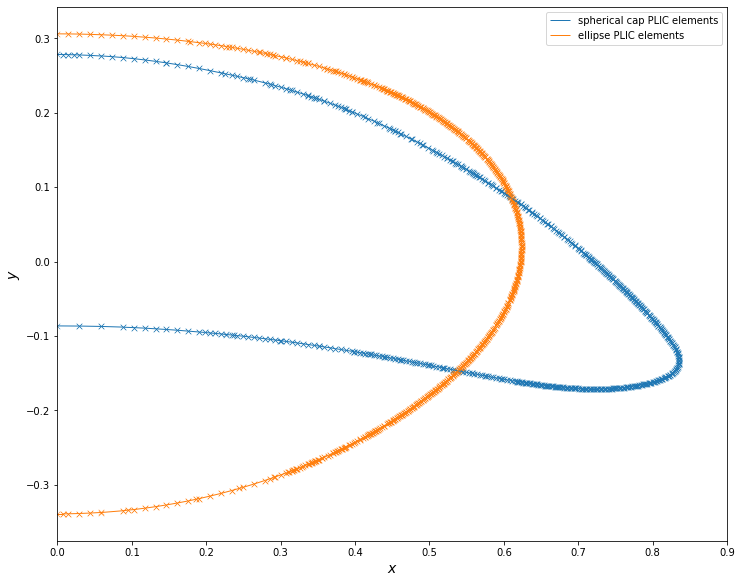

In [4]:
%matplotlib inline
# uncomment for interactive plot
# %matplotlib notebook
    
fontsize = 14

fig, ax = plt.subplots(1, figsize=(12, 10))

line_segments_cap = [[(data_cap.py[i], data_cap.px[i]),(data_cap.py[i+1], data_cap.px[i+1])]
                     for i in range(0, data_cap.shape[0] - 1, 2) ]
lc_cap = mc.LineCollection(line_segments_cap, linewidths=1, colors='C0', label=r"spherical cap PLIC elements")
ax.add_collection(lc_cap)
line_segments_eli = [[(data_eli.py[i], data_eli.px[i]),(data_eli.py[i+1], data_eli.px[i+1])]
                     for i in range(0, data_eli.shape[0] - 1, 2) ]
lc_eli = mc.LineCollection(line_segments_eli, linewidths=1, colors='C1', label=r"ellipse PLIC elements")
ax.add_collection(lc_eli)

ax.autoscale()

x = [i[0] for j in line_segments_cap for i in j]
y = [i[1] for j in line_segments_cap for i in j]
ax.scatter(x, y, marker='x', color='C0', s=30, linewidth=0.5)
x = [i[0] for j in line_segments_eli for i in j]
y = [i[1] for j in line_segments_eli for i in j]
ax.scatter(x, y, marker='x', color='C1', s=30, linewidth=0.5)

ax.set_aspect('equal')
ax.set_xlabel(r"$x$", fontsize=fontsize)
ax.set_ylabel(r"$y$", fontsize=fontsize)
ax.set_xlim(0.0, 0.9)
plt.legend()
plt.show()

## Parameterization<a id="parameterization"></a>
we transform to polar coordinates because of fixed argument range; we want to learn r(hpi)
x and y swaped such that bubbles rises in y

In [5]:
def polar_coordinates(px, py):
    '''Converts radius from Cartesian coordinates r(x,y) to polar coordinates r(phi).
    
    Parameters
    ----------
    px, py - array-like: x and y coordinates of PLIC points
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like: polar angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py))
    phi = np.arccos(py / radius)
    return radius, phi

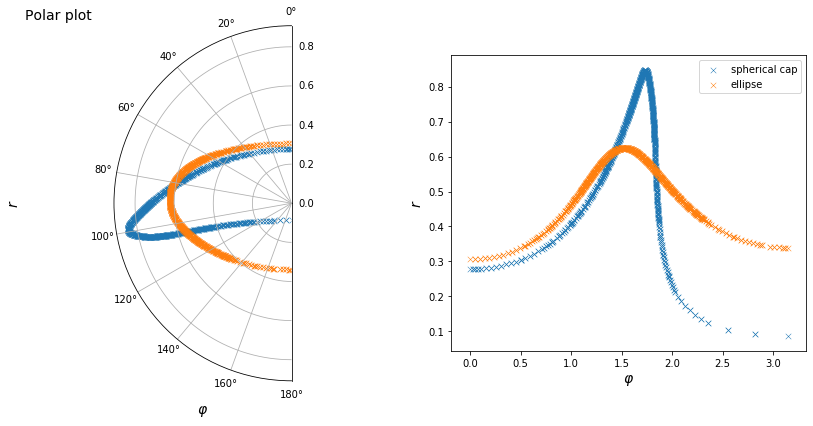

In [6]:
%matplotlib inline

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122)

radius_cap, phi_cap = polar_coordinates(data_cap.py.values, data_cap.px.values)
radius_eli, phi_eli = polar_coordinates(data_eli.py.values, data_eli.px.values)

ax1.set_theta_zero_location("N")
ax1.scatter(phi_cap, radius_cap, marker='x', color='C0', s=30, linewidth=0.5)
ax1.scatter(phi_eli, radius_eli, marker='x', color='C1', s=30, linewidth=0.5)
ax1.set_xlim(0.0, np.pi)
ax1.set_title("Polar plot", loc='left', fontsize=fontsize)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.scatter(phi_cap, radius_cap, marker='x', color='C0', s=30, linewidth=0.5, label=r"spherical cap")
ax2.scatter(phi_eli, radius_eli, marker='x', color='C1', s=30, linewidth=0.5, label=r"ellipse")
ax2.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax2.set_aspect(asp)
ax2.legend()
    
plt.show()

## Simple function approximation<a id="function_approximation"></a>

simple neural network with some hyperparameters: layers, neurons, activation function

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)

class SimpleMLP(torch.nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, n_layers=1, n_neurons=10, activation=torch.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(torch.nn.Linear(self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(torch.nn.Linear(self.n_neurons, self.n_outputs))
        
    def forward(self, x):
        for i_layer in range(self.n_layers):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

function uses MSE loss as loss function, whenever loss decreases we save model weights
function approximator for many inputs and many outputs (with minor modification)

In [8]:
def approximate_function(x, y, model, l_rate=0.001, max_iter=1000, path=None, verbose=100):
    '''Train MLP to approximate a function y(x).
       The training stops when the maximum number of training epochs is reached.
    
    Parameters
    ----------
    x - array-like    : argument of the function
    y - array-like    : function value at x
    model - SimpleMLP : PyTorch model which is adjusted to approximate the function
    l_rate - Float    : learning rate for weight optimization
    max_iter - Integer: maximum number of allowed training epochs
    path - String     : location to save model weights
    verbose - Integer : defines frequency for loss information output
    
    Returns
    -------
    model - SimpleMLP: trained version of the given model
    
    '''
    # convert coordinates to torch tensors
    x_tensor = torch.from_numpy(x).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y)
    # define loss function
    criterion = torch.nn.MSELoss()
    # define optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)
    
    # training loop
    best_loss = 1.0E5
    count = 0
    for e in range(1, max_iter+1):
        # backpropagation
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        loss = criterion(output.squeeze(dim=1), y_tensor)
        loss.backward()
        optimizer.step()
        # check error
        diff = output.squeeze(dim=1) - y_tensor
        max_diff = np.amax(np.absolute(diff.detach().numpy()))
        if loss.item() < best_loss:
            count += 1
            best_loss = loss.item()
            if count % verbose == 0:
                print("Loss/max. dev. decreased in epoch {}: {}/{}".format(e, loss.item(), max_diff))
            if path is not None:
                if count % verbose == 0: print("Saving model as {}".format(path))
                torch.save(model.state_dict(), path)
    return model.eval()

In [9]:
def set_path(name=None):
    if IN_COLAB:
        return F"/content/gdrive/My Drive/" + name
    else:
        return "models/" + name

## Direct approximation of the radius<a id="direct_approximation"></a>

straight forward approach

In [10]:
radius_model_cap_direct = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_cap_direct = approximate_function(phi_cap, radius_cap, radius_model_cap_direct, max_iter=1500,
                                               l_rate=0.01, path=set_path("radius_model_cap_direct.pt"))

Loss/max. dev. decreased in epoch 198: 0.023527750927666045/0.5738584592584179
Saving model as models/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 298: 0.02110305141826619/0.588679607479266
Saving model as models/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 398: 0.021091307916722014/0.5886754870003085
Saving model as models/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 498: 0.02108609994320023/0.5887036641419041
Saving model as models/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 598: 0.021083260908749155/0.5887219563243022
Saving model as models/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 737: 0.021080890076185084/0.5887321523352451
Saving model as models/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 837: 0.021079532602661478/0.5887273828749495
Saving model as models/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 937: 0.02107768854572432/0.5887103695508511
Saving model as models

In [11]:
radius_model_eli_direct = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_eli_direct = approximate_function(phi_eli, radius_eli, radius_model_eli_direct, max_iter=1500,
                                               l_rate=0.01, path=set_path("radius_model_eli_direct.pt"))

Loss/max. dev. decreased in epoch 263: 0.006279372004461198/0.22269251603414408
Saving model as models/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 363: 0.006279336735737929/0.22268772516222224
Saving model as models/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 463: 0.0062791738928397334/0.222668965808145
Saving model as models/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 563: 0.006274725337368535/0.22230163076891507
Saving model as models/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 663: 0.0038918454371433845/0.2094345525251637
Saving model as models/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 834: 1.329832321382618e-06/0.0072334522113391975
Saving model as models/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 1022: 4.354224874523192e-07/0.0052658676792191605
Saving model as models/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 1243: 2.17260212871825e-07/0.004431021935742574
Sa

Maximum relative deviation for spherical cap: 99.33% at angle 3.14.
Maximum relative deviation for ellipse: 1.28% at angle 1.71.


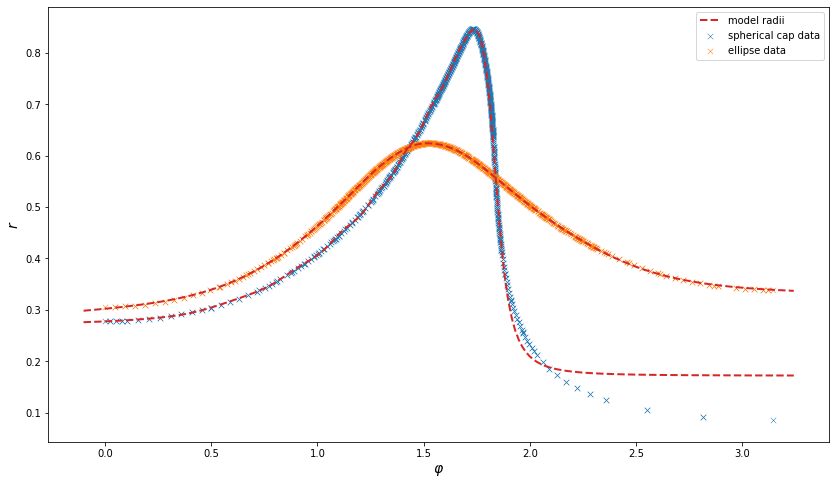

In [12]:
fig, ax = plt.subplots(figsize=(14, 8))

eval_phi = np.linspace(-0.1, np.pi+0.1, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
# load best weights and compute forward pass
radius_model_cap_direct.load_state_dict(torch.load(set_path("radius_model_cap_direct.pt")))
model_radius_cap = radius_model_cap_direct.forward(phi_tensor).detach().squeeze().numpy()
radius_model_eli_direct.load_state_dict(torch.load(set_path("radius_model_eli_direct.pt")))
model_radius_eli = radius_model_eli_direct.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation
phi_cap_tensor = torch.from_numpy(phi_cap).unsqueeze_(-1)
phi_eli_tensor = torch.from_numpy(phi_eli).unsqueeze_(-1)
model_radius_cap_data = radius_model_cap_direct.forward(phi_cap_tensor).detach().squeeze().numpy()
model_radius_eli_data = radius_model_eli_direct.forward(phi_eli_tensor).detach().squeeze().numpy()
diff_cap = np.absolute(model_radius_cap_data - radius_cap)
diff_eli = np.absolute(model_radius_eli_data - radius_eli)
max_pos_cap = np.argmax(diff_cap)
max_pos_eli = np.argmax(diff_eli)
print(r"Maximum relative deviation for spherical cap: {:2.2f}% at angle {:2.2f}.".format(
      np.amax(diff_cap)/radius_cap[max_pos_cap] * 100, phi_cap[max_pos_cap]))
print(r"Maximum relative deviation for ellipse: {:2.2f}% at angle {:2.2f}.".format(
      np.amax(diff_eli)/radius_eli[max_pos_eli] * 100, phi_cap[max_pos_eli]))

ax.plot(eval_phi, model_radius_cap, linewidth=2, linestyle="--", c='C3', label=r"model radii")
ax.plot(eval_phi, model_radius_eli, linewidth=2, linestyle="--", c='C3')

ax.scatter(phi_cap, radius_cap, marker='x', color='C0', s=30, linewidth=0.5, label=r"spherical cap data")
ax.scatter(phi_eli, radius_eli, marker='x', color='C1', s=30, linewidth=0.5, label=r"ellipse data")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.legend()
plt.show()

## Using prior/domain knowledge<a id="prior_knowledge"></a>

### Re-scaling the data<a id="rescaling"></a>

We how bubble is going to look like -> we can create simple function approximation and use them to simplify the approximation problem
vanishing gradient problem, especially with sigmoid functions; the output should be close to one be gradient of sigmoid vanishes in that range; gradient of r w.r.t. phi becomes very small -> rescale data to 0...1

In [13]:
from scipy.special import expit

def ellipse_radius(phi, a, b):
    '''Compute the radius of an ellipse.
      
    Parameters
    ----------
    phi - array-like : polar angle
    a - Float        : long half axis length
    b - Float        : short half axis length
    
    Returns
    -------
    radius - array-like : ellipse radius
    
    '''
    return a * b / np.sqrt(np.square(a * np.cos(phi)) + np.square(b * np.sin(phi)))


def spherical_cap_radius(phi, a, b, h, phi_max, R_max):
    '''Compute the radius of a spherical cap w.r.t. the cap center.
      
    Parameters
    ----------
    phi - array-like : polar angle w.r.t. to cap center
    a - Float        : half axis length of the cap
    b - Float        : distance between cap center and bottom
    h - Float        : cap height
    phi_max - Float  : polar angle of R_max
    R_max - Float    : maximum radius of the cap w.r.t. its center
    
    Returns
    -------
    radius - array-like : spherical cap radius
    
    '''
    R_cap = (a**2 + h**2) / (2 * h)
    h_1 = h - b
    term_1 = np.cos(phi) * (h_1 - R_cap)
    term_2 = np.square(np.cos(phi) * (R_cap - h_1)) - h_1 * (h_1 - 2.0 * R_cap)
    R_1 = term_1 + np.sqrt(term_2)
    R_2 = np.minimum(b / np.cos(np.pi - phi), np.ones(len(phi)) * R_max)
    R_2 = np.where(R_2 > 0, R_2, R_max)
    return np.minimum(R_1, R_2)

Spherical cap data:
-------------------
The relative variance of the original radius is 0.0489.
The relative variance of the scaled radius is 0.0162.

Ellipse data:
-------------
The relative variance of the original radius is 0.0119.
The relative variance of the scaled radius is 0.0004.


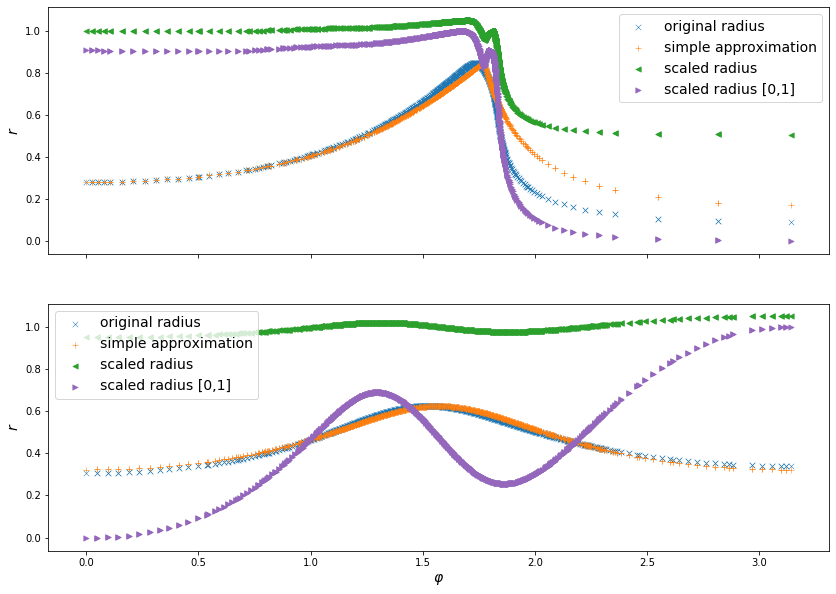

In [14]:
# simple approximation of spherical cap
long_axis_cap = abs(np.amax(data_cap.py.values) - np.amin(data_cap.py.values))
height_cap = abs(np.amax(data_cap.px.values) - np.amin(data_cap.px.values))
offset = abs(np.amin(data_cap.px.values))
phi_max = phi_cap[np.argmax(radius_cap)]
R_max = np.amax(radius_cap)
radius_cap_simple = spherical_cap_radius(phi_cap, long_axis_cap, offset, height_cap, phi_max, R_max)
# simple approximation of ellipse
long_axis_eli = abs(np.amax(data_eli.py.values) - np.amin(data_eli.py.values))
short_axis_eli = abs(np.amax(data_eli.px.values) - np.amin(data_eli.px.values)) * 0.5
radius_eli_simple = ellipse_radius(phi_eli, long_axis_eli, short_axis_eli)
# rescaling of the original radii
radius_cap_scaled = radius_cap / radius_cap_simple
radius_eli_scaled = radius_eli / radius_eli_simple
scaler_cap = MinMaxScaler()
scaler_eli = MinMaxScaler()
radius_cap_scaled_01 = np.squeeze(scaler_cap.fit_transform(radius_cap_scaled.reshape(-1,1)))
radius_eli_scaled_01 = np.squeeze(scaler_eli.fit_transform(radius_eli_scaled.reshape(-1,1)))

# compute the relative variance (index of dispersion) of original and scaled data
print("Spherical cap data:")
print("-" * len("Spherical cap data:"))
print("The relative variance of the original radius is {:1.4f}.".format(np.var(radius_cap) / np.mean(radius_cap)))
print("The relative variance of the scaled radius is {:1.4f}.".format(np.var(radius_cap_scaled) / np.mean(radius_cap_scaled)))
print("\nEllipse data:")
print("-" * len("Ellipse data:"))
print("The relative variance of the original radius is {:1.4f}.".format(np.var(radius_eli) / np.mean(radius_eli)))
print("The relative variance of the scaled radius is {:1.4f}.".format(np.var(radius_eli_scaled) / np.mean(radius_eli_scaled)))

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10), sharex=True)
ax1.scatter(phi_cap, radius_cap, marker='x', color='C0', s=30, linewidth=0.5, label=r"original radius")
ax1.scatter(phi_cap, radius_cap_simple, marker='+', color='C1', s=30, linewidth=0.5, label=r"simple approximation")
ax1.scatter(phi_cap, radius_cap_scaled, marker='<', color='C2', s=30, linewidth=0.5, label=r"scaled radius")
ax1.scatter(phi_cap, radius_cap_scaled_01, marker='>', color='C4', s=30, linewidth=0.5, label=r"scaled radius [0,1]")
ax1.set_ylabel(r"$r$", fontsize=fontsize)
ax1.legend(fontsize=fontsize)

ax2.scatter(phi_eli, radius_eli, marker='x', color='C0', s=30, linewidth=0.5, label=r"original radius")
ax2.scatter(phi_eli, radius_eli_simple, marker='+', color='C1', s=30, linewidth=0.5, label=r"simple approximation")
ax2.scatter(phi_eli, radius_eli_scaled, marker='<', color='C2', s=30, linewidth=0.5, label=r"scaled radius")
ax2.scatter(phi_eli, radius_eli_scaled_01, marker='>', color='C4', s=30, linewidth=0.5, label=r"scaled radius [0,1]")
ax2.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)
ax2.legend(fontsize=fontsize)
plt.show()

In [15]:
radius_model_cap_scaled = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_cap_scaled = approximate_function(phi_cap, radius_cap_scaled_01, radius_model_cap_scaled, max_iter=1500,
                                           l_rate=0.01, path=set_path("radius_model_cap_scaled.pt"))

Loss/max. dev. decreased in epoch 217: 0.05254168289357386/0.8398243659675816
Saving model as models/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 399: 0.0014162133778446969/0.10809616091893359
Saving model as models/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 499: 0.0013950972265103449/0.11103085597081863
Saving model as models/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 599: 0.0013729926984001263/0.11204022662416302
Saving model as models/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 699: 0.0013193869576754928/0.11555060960925112
Saving model as models/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 799: 0.0010975012526803982/0.11994055648573043
Saving model as models/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 899: 0.0008349200388320202/0.10330147104719567
Saving model as models/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 1074: 0.0003709392679387689/0.07580475361362293
Savi

In [16]:
radius_model_eli_scaled = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_eli_scaled = approximate_function(phi_eli, radius_eli_scaled_01, radius_model_eli_scaled, max_iter=1500,
                                           l_rate=0.01, path=set_path("radius_model_eli_scaled.pt"))

Loss/max. dev. decreased in epoch 235: 0.03417527999542799/0.5321907169099123
Saving model as models/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 335: 0.034157096336963684/0.5319557743353119
Saving model as models/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 444: 0.007320763961875946/0.46290159285352384
Saving model as models/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 600: 0.00010994196757672676/0.04930946460217778
Saving model as models/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 781: 5.235310992407392e-05/0.03402753700090111
Saving model as models/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 884: 3.3498322195063134e-05/0.027498039432092725
Saving model as models/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 1097: 2.3419888619761762e-05/0.023588218611869105
Saving model as models/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 1375: 1.71668751455772e-05/0.020761627404187744
S

Maximum relative deviation sherical cap: 6.42% at angle 1.77.
Maximum relative deviation ellipse: 1.72% at angle 2.47.


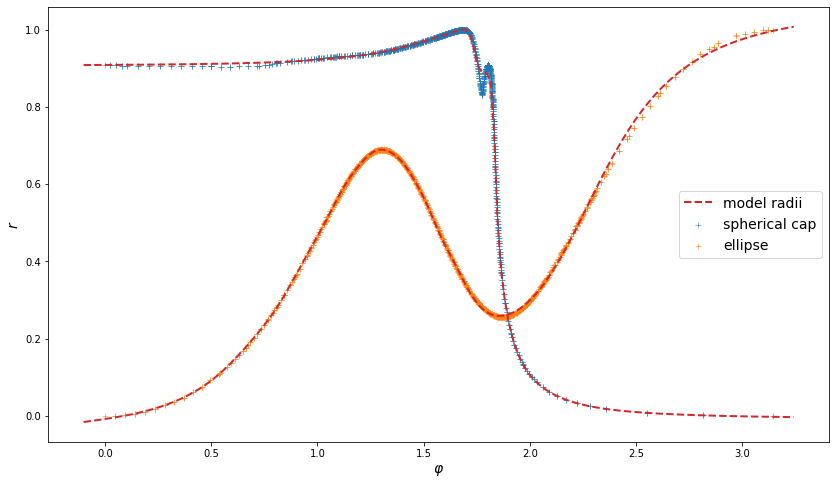

In [17]:
# load best weights and compute forward pass
radius_model_cap_scaled.load_state_dict(torch.load(set_path("radius_model_cap_scaled.pt")))
model_radius_cap = radius_model_cap_scaled.forward(phi_tensor).detach().squeeze().numpy()
radius_model_eli_scaled.load_state_dict(torch.load(set_path("radius_model_eli_scaled.pt")))
model_radius_eli = radius_model_eli_scaled.forward(phi_tensor).detach().squeeze().numpy()

# evaluate maximum relative deviation
model_radius_cap_data = radius_model_cap_scaled.forward(phi_cap_tensor).detach().squeeze().numpy()
model_radius_eli_data = radius_model_eli_scaled.forward(phi_eli_tensor).detach().squeeze().numpy()
diff_cap = np.absolute(model_radius_cap_data - radius_cap_scaled_01)
diff_eli = np.absolute(model_radius_eli_data - radius_eli_scaled_01)
max_pos_cap = np.argmax(diff_cap)
max_pos_eli = np.argmax(diff_eli)
print(r"Maximum relative deviation sherical cap: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff_cap)/radius_cap_scaled[max_pos_cap] * 100, phi_cap[max_pos_cap]))
print(r"Maximum relative deviation ellipse: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff_eli)/radius_eli_scaled[max_pos_eli] * 100, phi_eli[max_pos_eli]))

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(eval_phi, model_radius_cap, linewidth=2, linestyle="--", c='C3', label=r"model radii")
ax.plot(eval_phi, model_radius_eli, linewidth=2, linestyle="--", c='C3')
ax.scatter(phi_cap, radius_cap_scaled_01, marker='+', color='C0', s=30, linewidth=0.5, label=r"spherical cap")
ax.scatter(phi_eli, radius_eli_scaled_01, marker='+', color='C1', s=30, linewidth=0.5, label="ellipse")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()

Maximum relative deviation sherical cap: 3.50% at angle 1.77.
Maximum relative deviation ellipse: 0.18% at angle 2.47.


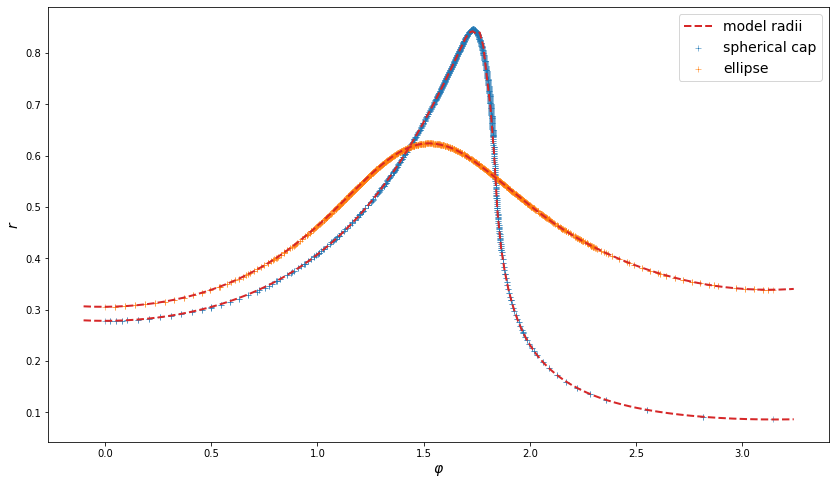

In [18]:
# transform back to compare to original data
cap_radius_scaled = np.squeeze(scaler_cap.inverse_transform(model_radius_cap.reshape(-1, 1)))
eli_radius_scaled = np.squeeze(scaler_eli.inverse_transform(model_radius_eli.reshape(-1, 1)))
cap_radius_final = cap_radius_scaled * spherical_cap_radius(eval_phi, long_axis_cap, offset, height_cap, phi_max, R_max)
eli_radius_final = eli_radius_scaled * ellipse_radius(eval_phi, long_axis_eli, short_axis_eli)
# pointwise comparison
cap_radius_data_scaled = np.squeeze(scaler_cap.inverse_transform(model_radius_cap_data.reshape(-1, 1)))
eli_radius_data_scaled = np.squeeze(scaler_eli.inverse_transform(model_radius_eli_data.reshape(-1, 1)))
final_cap_data_model = cap_radius_data_scaled * radius_cap_simple
final_eli_data_model = eli_radius_data_scaled * radius_eli_simple
diff_cap = np.absolute(radius_cap - final_cap_data_model)
diff_eli = np.absolute(radius_eli - final_eli_data_model)
max_pos_cap = np.argmax(diff_cap)
max_pos_eli = np.argmax(diff_eli)
print(r"Maximum relative deviation sherical cap: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff_cap)/radius_cap[max_pos_cap] * 100, phi_cap[max_pos_cap]))
print(r"Maximum relative deviation ellipse: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff_eli)/radius_eli[max_pos_eli] * 100, phi_eli[max_pos_eli]))

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(eval_phi, cap_radius_final, linewidth=2, linestyle="--", c='C3', label=r"model radii")
ax.plot(eval_phi, eli_radius_final, linewidth=2, linestyle="--", c='C3')
ax.scatter(phi_cap, radius_cap, marker='+', color='C0', s=30, linewidth=0.5, label=r"spherical cap")
ax.scatter(phi_eli, radius_eli, marker='+', color='C1', s=30, linewidth=0.5, label="ellipse")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()

### Adding artificial data<a id="artificial_data"></a>

We can enforce certain mathematical properties of our function by adding artificial data; we could also modify loss function and include gradient

In [19]:
phi_threshold = 0.5
phi_add = []
radius_add = []

for p, r in zip(phi_cap, radius_cap):
    if p < phi_threshold:
        phi_add.append(-p)
        radius_add.append(r)
    if p > np.pi - phi_threshold:
        phi_add.append(2 * np.pi - p)
        radius_add.append(r)
        
phi_cap_extended = np.concatenate((phi_cap, np.asarray(phi_add)))
radius_cap_extended = np.concatenate((radius_cap, np.asarray(radius_add)))
print("Added {} points to the training data.".format(radius_cap_extended.shape[0] - radius_cap.shape[0]))

Added 28 points to the training data.


### Creating ensemble models<a id="ensemble_models"></a>

we could create the same model architcture in one shot; training is different because loss function is different

In [20]:
class EnsembleModel(torch.nn.Module):
    def __init__(self, model_1, model_2, diff_train):
        super(EnsembleModel, self).__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.diff = diff_train
        self.diff_min = torch.min(self.diff)
        self.diff_range = torch.max(self.diff) - self.diff_min
        
    def forward(self, x):
        x_1 = self.model_1(x)
        x_2 = self.model_2(x)
        x_2 = x_2 * self.diff_range + self.diff_min
        return x_1 + x_2

In [21]:
phi_ex_tensor = torch.from_numpy(phi_cap_extended).unsqueeze_(-1)
radius_ex_tensor = torch.from_numpy(radius_cap_extended).unsqueeze_(-1)

def train_ensemble_model(layers_m1, layers_m2, neurons_m1, neurons_m2):
    print("Configuration - model 1: {} layers, {} neurons; model 2: {} layers, {} neurons".format(
        layers_m1, neurons_m1, layers_m2, neurons_m2))
    # train model 1
    model_1 = SimpleMLP(n_layers=layers_m1, n_neurons=neurons_m1)
    model_1 = approximate_function(phi_cap_extended, radius_cap_extended, model_1, max_iter=1500,
                               l_rate=0.01, path=set_path("model_1.pt"), verbose=2000)
    model_1.load_state_dict(torch.load(set_path("model_1.pt")))  
    # compute deviation from training data, rescale to [0,1]
    diff = radius_ex_tensor - model_1(phi_ex_tensor)
    diff_min = torch.min(diff)
    diff_range = torch.max(diff) - diff_min
    diff_norm = (diff - diff_min) / diff_range
    # train model 2
    model_2 = SimpleMLP(n_layers=layers_m2, n_neurons=neurons_m2)
    model_2 = approximate_function(phi_cap_extended, diff_norm.detach().squeeze().numpy(), model_2, max_iter=1500,
                                   l_rate=0.01, path=set_path("model_2.pt"), verbose=2000)
    model_2.load_state_dict(torch.load(set_path("model_2.pt")))
    # create and evaluate ensemble model
    ensemble = EnsembleModel(model_1, model_2, diff)
    ensemble_radius_data = ensemble(phi_ex_tensor).detach().squeeze().numpy()
    final_diff = np.absolute(radius_cap_extended - ensemble_radius_data)
    max_pos = np.argmax(final_diff)
    return np.amax(final_diff)/radius_cap_extended[max_pos_cap], model_1, model_2

n_layers = range(1, 11)
n_neurons = range(10, 60, 10)
min_error = 100

for i in range(5):
    print("Iteration {}\n------------".format(i))
    layers = np.random.choice(n_layers, 2)
    neurons = np.random.choice(n_neurons, 2)
    error, model_1, model_2 = train_ensemble_model(layers[0], layers[1], neurons[0], neurons[1])
    if error < min_error:
        print("\033[1mError decreased to {:2.2f}%\033[0m. Saving model.".format(error * 100))
        min_error = error
        torch.save(model_1.state_dict(), set_path("model_1_final.pt"))
        torch.save(model_2.state_dict(), set_path("model_2_final.pt"))
        best_layers = layers
        best_neurons = neurons
    print("")

Iteration 0
------------
Configuration - model 1: 9 layers, 40 neurons; model 2: 7 layers, 10 neurons
Error decreased to 13.44%. Saving model.

Iteration 1
------------
Configuration - model 1: 5 layers, 30 neurons; model 2: 8 layers, 50 neurons
Error decreased to 2.83%. Saving model.

Iteration 2
------------
Configuration - model 1: 7 layers, 50 neurons; model 2: 10 layers, 50 neurons
Error decreased to 1.28%. Saving model.

Iteration 3
------------
Configuration - model 1: 1 layers, 50 neurons; model 2: 9 layers, 50 neurons

Iteration 4
------------
Configuration - model 1: 4 layers, 10 neurons; model 2: 5 layers, 20 neurons



In [22]:
# recreate best ensemble model and compute final output
model_1 = SimpleMLP(n_layers=best_layers[0], n_neurons=best_neurons[0])
model_2 = SimpleMLP(n_layers=best_layers[1], n_neurons=best_neurons[1])
model_1.load_state_dict(torch.load(set_path("model_1_final.pt")))
model_2.load_state_dict(torch.load(set_path("model_2_final.pt")))
diff = radius_ex_tensor - model_1(phi_ex_tensor)
ensemble = EnsembleModel(model_1, model_2, diff)
ensemble_radius_data = ensemble(phi_ex_tensor).detach().squeeze().numpy()
final_diff = np.absolute(radius_cap_extended - ensemble_radius_data)
max_pos = np.argmax(final_diff)
print(r"Maximum relative deviation sherical cap: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(final_diff)/radius_cap_extended[max_pos_cap] * 100, phi_cap_extended[max_pos]))

Maximum relative deviation sherical cap: 1.28% at angle 1.79.


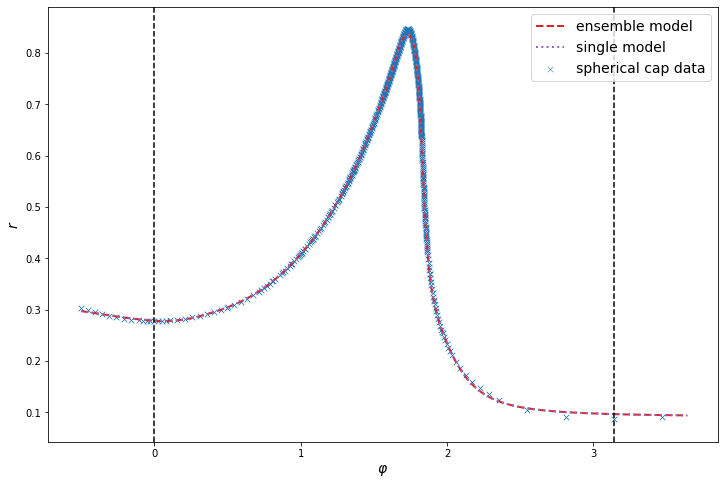

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
eval_phi = np.linspace(-0.5, np.pi+0.5, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
ensemble_radius = ensemble(phi_tensor).detach().squeeze().numpy()
model_1_radius = model_1(phi_tensor).detach().squeeze().numpy()

ax.plot(eval_phi, ensemble_radius, linewidth=2, linestyle="--", c='C3', label=r"ensemble model")
ax.plot(eval_phi, model_1_radius, linewidth=2, linestyle=":", c='C4', label=r"single model")
ax.scatter(phi_cap_extended, radius_cap_extended, marker='x', color='C0', s=30, linewidth=0.5, label=r"spherical cap data")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.axvline(0.0, 0.0, 1.0, color='k', linestyle='--')
ax.axvline(np.pi, 0.0, 1.0, color='k', linestyle='--')
plt.legend(fontsize=fontsize)
plt.show()

## Final notes<a id="final_notes"></a>

- mapping of other fields to shape; allows to compute gradients, useful for optimization
- networks strong when feature space high-dimensional
- model training is never deterministic; iterative search sometimes necessary
- many layers, sigmoid suffers from vanishing gradient, change activation function, e.g., to *torch.relu*
- create a custom loss funtion that weights each individual inversly to the distribution of the training data over the polar angle.